# Tuning of the PI controller

PI controller for the current in a three phase inverter.

Control structure: for each channel (*d* and *q*):

> (i* - i)  → | C | → u → | H | → i

Pierre Haessig — May 2015

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.signal as sig

In [2]:
%matplotlib inline

In [3]:
from IPython.html.widgets import interact, interactive, FloatSlider

:0: FutureWarning: IPython widgets are experimental and may change in the future.


## 1) Models of the inverter

Because of:
* expressing the electrical equation in the rotating dq frame
* and because of the feedforward terms

we control the inverter as two independant and equal channels, with a simple Voltage→Current transfer function:

$$ H(s) = I(s) / U(s)$$

cf. Notebook about [modeling an inverter in the dq frame](dq_inverter_model.ipynb).


### Modeling options

#### Integrator (pure inductance)

Either we consider only the inductance:
$$H(s) = \frac{1}{L s}$$

#### First order (RL circuit)

or also a parasitic resistance:

$$H(s) = \frac{1}{R + Ls} = \frac{1/R}{1 + \tau s} $$

with a time constant $\tau = L/R$

#### First order with delay

In addition, we can also consider the delay induced by the sampling of the PWM modulation.

$$\tilde{H}(s) = H(s) e^{-T_d s}$$

with $T_d \approx 1/f_{switch}$ (or 1/2 of this ?)

In [312]:
f_switch = 10e3 # Hz
Td = 1/f_switch

In [101]:
L = 2e-3 # H
R = 10e-3 # Ohms

sys = sig.lti([1], [L, R])
sys

lti(
array([[-5.]]),
array([[ 1.]]),
array([[ 500.]]),
array([ 0.])
)

Properties of the grid inductance:

* impedance X = Lω
* inductive voltage drop at 50 Hz
* R/X ratio at 50 Hz

In [229]:
X_50Hz = 2*np.pi*50*L
I_max = 20e3 / 230 / 3 # 20 kVA
print(u'X = Lω = {:.3f} Ω'.format(X_50Hz))
print(u'I.X = {:.0f} V, for I={:.0f} A'.format(2*np.pi*50*L*I_max, I_max))
print('R/X = {:.3f}'.format(R/X_50Hz))

X = Lω = 0.628 Ω
I.X = 18 V, for I=29 A
R/X = 0.016


Rejection of PWM switcing signal at 10 kHz

$$\Delta I = \frac{\Delta U_{PWM} }{2\pi L f_{PWM}}$$

In [318]:
V_dc = 600
V_dc/(2*np.pi*f_switch*L)

4.7746482927568605

→ about 5 A of peak to peak oscillation in the current. Not that good, not that bad.

*Helper: Plotting function for a Bode diagram*

In [197]:
w_min = 10
w_max = 10000
w_list = np.logspace(1, 4) # ~.1s to .1ms time constants (~ 1 Hz to 1000 Hz)

phase_locator = mpl.ticker.MultipleLocator(90)
phase_locator_min = mpl.ticker.MultipleLocator(30)


def bode_plot(w, mag, phase):
    fig, (ax1, ax2) = plt.subplots(2,1, sharex=True)
    ax1.set(xscale='log', ylabel='Gain (dB)')
    ax1.axes.locator_params('y', nbins=5)
    ax1.grid(True)
    ax2.set(xscale='log', ylabel=u'phase (°)', xlabel=u'puls. ω (rad/s)')
    ax2.yaxis.set_major_locator(phase_locator)
    ax2.grid(True)
    
    ax1.plot(w, mag)
    ax2.plot(w, phase)
    return ax1, ax2

### Bode diagram of the inverter

$$H = U/I$$

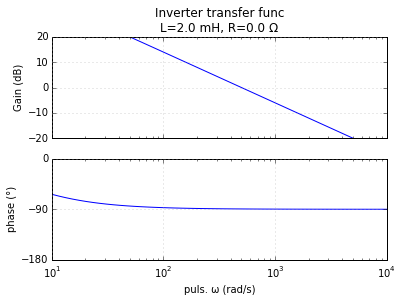

In [230]:
@interact(mL=[0.,2000*L], R=[0., 10*R, 0.1*R])
def sys_bode(mL=L*1000, R=R, delay=False):  
    L = mL * 1e-3
    sys = sig.lti([1], [L, R])
    w, mag, phase = sys.bode(w_list)
    if delay:
        phase -= w_list*Td*180/np.pi
    ax1, ax2 = bode_plot(w, mag, phase)
    #ax1.plot(w, dB(1/(w*L)), 'b--', label='1/Ls asympt')
    if R>0:
        # mark the transistion frequency
        tau = L/float(R)
        ax1.plot(1/tau, -20*np.log10(R)-3, 'bo')
        ax2.plot(1/tau, -45, 'bo')
    ax1.set(title=u'Inverter transfer func \nL={:.1f} mH, R={:.1f} Ω'.format(L*1000,R))
    ax1.set_ylim(-20,20)
    ax2.set_ylim(-180, 0)
    ax2.set_xlim(w_min, w_max)

Observation: for the range of pulsation which is interesting for the current control, the system is essentially inductive (integrator).

## 2) PI Controller

PI controller equation (other parametrizations are possible)

$$C(s) = K_p (1+\frac{1}{T_i s})$$

In [260]:
Kp = 2.
Ti = 0.010 # s

ctrl = sig.lti([Kp*Ti, Kp], [Ti, 0])
ctrl

lti(
array([[-0.]]),
array([[ 1.]]),
array([[ 200.]]),
array([ 2.])
)

Range of parameters for plot interactive changes:

In [261]:
interact_params = dict(
    mL=[0., 2000*L],
    R=[0., 10*R, 0.1*R],
    Kp=[0.,10],
    mTi=[0., Ti*10000, 1]
)

### Bode diagram of the controller

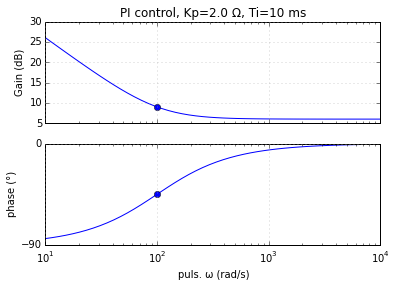

In [262]:
def ctrl_bode(Kp=Kp, mTi=Ti*1000):
    Ti = mTi *  1e-3
    ctrl = sig.lti([Kp*Ti, Kp], [Ti, 0])
    w, mag, phase = ctrl.bode(w_list)
    ax1, ax2 = bode_plot(w, mag, phase)
    
    ax1.set_title(u'PI control, Kp={:.1f} Ω, Ti={:.0f} ms'.format(Kp,Ti*1000))
    
    if Ti>0:
        # mark the transistion frequency
        ax1.plot(1/Ti, 20*np.log10(Kp)+3, 'bo')
        ax2.plot(1/Ti, -45, 'bo')
    

interact(ctrl_bode, **interact_params);

## 3) Analysis of the open loop transfer function

issue: the series connection of two systems is not implemented

In [263]:
H_ol = ctrl*sys

TypeError: unsupported operand type(s) for *: 'lti' and 'lti'

solution: do the connection in the frequency domain, manually:

In [264]:
H_ol = ctrl.freqresp(w_list)[1] * sys.freqresp(w_list)[1]

### Computing the phase margin

In [265]:
def dB(x):
    return 20*np.log10(np.abs(x))

def deg(x):
    if x.ndim>0: # unwrap
        return np.unwrap(np.angle(x))*180/np.pi
    else: # unwrap makes no sense (and fails) for scalars
        return np.angle(x, deg=True)

In [266]:
def phase_margin(H_ol):
    'phase margin for open loop tranfer function `H_ol` (array of complex numbers)'
    # frequency of crossing 0dB
    i1 = np.nonzero(dB(H_ol)>0)[0][-1] # last index with gain above 0dB
    i2 = np.nonzero(dB(H_ol)<0)[0][0] # first index with gain below
    
    i_0dB = i2
    
    #w_cross = w[i_0dB]
    margin = 180 + deg(H_ol[i_0dB])
    return margin, i_0dB

Phase margin for the currently defined system

In [267]:
phase_margin(H_ol)[0]

84.823259075850018

0dB pulsation

In [268]:
w_list[phase_margin(H_ol)[1]]

1048.1131341546852

### Plot of the open loop transfer

####  Bode plot

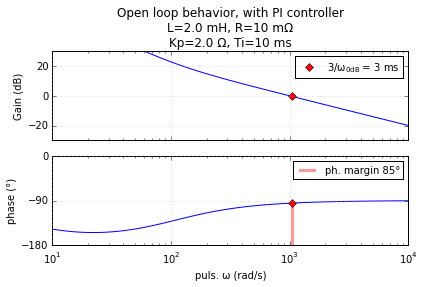

In [363]:
def open_plot(mL=L*1000,R=R, Kp=Kp, mTi=Ti*1000, delay=False):
    L = mL*1e-3
    Ti = mTi*1e-3
    
    sys = sig.lti([1], [L, R])
    ctrl = sig.lti([Kp*Ti, Kp], [Ti, 0])
    H_ol = ctrl.freqresp(w_list)[1] * sys.freqresp(w_list)[1]
    
    if delay:
        H_ol *= np.exp(-1j*w_list*Td)
    
    ax1, ax2 = bode_plot(w_list, dB(H_ol), deg(H_ol));
    
    title = u'''Open loop behavior, with PI controller
L={:.1f} mH, R={:.0f} mΩ
Kp={:.1f} Ω, Ti={:.0f} ms'''.format(L*1e3,R*1e3,Kp,Ti*1e3)
    ax1.set_title(title)
    #ax1.plot(w, dB(Kp/(w*L)), 'b--', label='Kp/Ls asympt')
    
    # phase margin
    margin, i_0dB = phase_margin(H_ol)
    w_0dB = w_list[i_0dB]
    ax1.plot(w_0dB, 0, 'rD', label='3/$\omega_{{0dB}}$ = {:.0f} ms'.format(3e3/w_0dB))
    ax1.legend(loc='upper right', numpoints=1)
    ax1.set_ylim(-30,30)
    
    ax2.plot(w_0dB, -180+margin, 'rD')
    ax2.vlines(w_0dB, -180, -180+margin, label=u'ph. margin {:.0f}°'.format(margin),
               colors='red', linewidth=3, alpha=0.4)
    ax2.legend(loc='upper right')
    ax2.set_ylim(-180, 0)
    plt.tight_layout()
    #plt.savefig('Bode_diagram.png', dpi=150)

interact(open_plot, **interact_params);

#### Black-Nichols chart

Plot the same data (open loop tranfer), but in Black plan (phase, gain_dB).

On this plot, we can superimpose Nichols' isogain lines.

Parametric curve equation for a closed loop linear gain $g$:

$$z = 1- re^{i\theta}$$

with
$$r(\theta) = \frac{\sqrt{g^2 -1 + \cos^2 \theta} - \cos \theta}{g^2 - 1}$$

observation: $r \sim 1/g$ for big values of gain $g$.

In [281]:
# helper function
def isogain_pts(gain_dB, n_pts=100):
    '''generate the set of complex numbers `z` which have a given closed loop gain `gain_dB`
    that is, solutions of 20 log10 |z/(1+z)| = gain_dB, with gain_dB > 0
    '''
    assert gain_dB>0 # formula below not valid for negative gains
    th = np.linspace(-np.pi/2, np.pi*2 - np.pi/2, n_pts) 
    g = 10**(gain_dB/20.)
    r = (np.sqrt(g**2 - 1 + np.cos(th)**2) - np.cos(th)) / \
        (g**2 - 1)
    z = -1 + r*np.exp(1j*th)
    return z

In [282]:
# Check that the function is working properly
z = isogain_pts(gain_dB=3, n_pts=10)
20 * np.log10 (np.abs(z/(1+z)))

array([ 3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.])

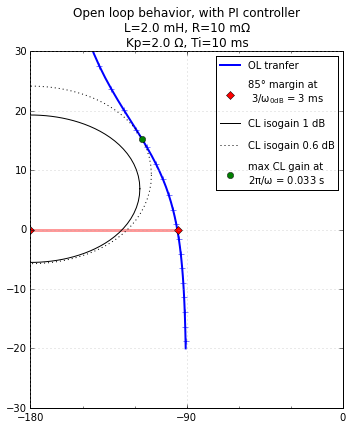

In [364]:
def black_plot(mL=L*1000,R=R, Kp=Kp, mTi=Ti*1000, delay=False):
    L = mL*1e-3
    Ti = mTi*1e-3
    
    sys = sig.lti([1], [L, R])
    ctrl = sig.lti([Kp*Ti, Kp], [Ti, 0])
    H_ol = ctrl.freqresp(w_list)[1] * sys.freqresp(w_list)[1]
    
    if delay:
        H_ol *= np.exp(-1j*w_list*Td)
    
    fig = plt.figure(figsize=(5,6))
    plt.plot(deg(H_ol), dB(H_ol), 'b-', label='OL tranfer', lw=2)
    plt.plot(deg(H_ol[::2]), dB(H_ol[::2]), '+')
    
    # phase margin
    margin, i_0dB = phase_margin(H_ol)
    w_0dB = w_list[i_0dB]
    margin_label = u'{:.0f}° margin at\n 3/$\omega_{{0dB}}$ = {:.0f} ms'.format(margin, 3e3/w_0dB)
    plt.plot(-180, 0, 'rD') # critical point -1
    plt.plot(-180+margin, 0, 'rD', label=margin_label)
    plt.hlines(0, -180, -180+margin,
               colors='red', linewidth=3, alpha=0.4)
    
    # Add a Nichols isogain contours
    z = isogain_pts(gain_dB=1)
    plt.plot(deg(z), dB(z), 'k-', label='CL isogain 1 dB')
    
    GdB_max = dB(np.max(np.abs(H_ol/(1+H_ol))))
    if GdB_max > 0:
        z = isogain_pts(GdB_max)
        plt.plot(deg(z), dB(z), 'k:', label='CL isogain {:.1f} dB'.format(GdB_max))
    
        # Point the oscillation period of the maximum CL gain
        i_max = np.argmax(np.abs(H_ol/(1+H_ol)))
        w_max = w_list[i_max]
        plt.plot(deg(H_ol[i_max]), dB(H_ol[i_max]), 'o', label='max CL gain at \n$2\pi/\omega$ = {:.3f} s'.format(2*np.pi/w_max))
    
    ax = plt.gca()
    ax.xaxis.set_major_locator(phase_locator)
    ax.xaxis.set_minor_locator(phase_locator_min)
    ax.legend(loc='upper right', numpoints=1, labelspacing=1.2)
    ax.grid(True)
    
    title = u'''Open loop behavior, with PI controller
L={:.1f} mH, R={:.0f} mΩ
Kp={:.1f} Ω, Ti={:.0f} ms'''.format(L*1e3,R*1e3,Kp,Ti*1e3)
    plt.title(title)
    plt.xlim(-180, 0)
    plt.ylim(-30, 30)
    
    fig.tight_layout()
    fig.savefig('Black_diagram.png', dpi=150)

interact(black_plot, **interact_params);

Note : to avoid transcient overshoots, it is important that the closed-loop gain stays always lower than 1 dB (~ 1.12)

## 4) Closed loop behavior

#### Behavior in the frequency domain

Closed loop transfer function:

In [284]:
H_cl = H_ol/(1+H_ol)

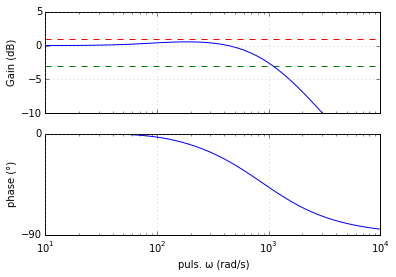

In [285]:
ax1, ax2 = bode_plot(w_list, dB(H_cl), deg(H_cl));
ax1.set_ylim(-10, 5)
ax1.hlines(1, w_min, w_max, linestyles='dashed', color='r');
ax1.hlines(-3, w_min, w_max, linestyles='dashed', color='g');

### Time domain:  transient behavior, step response

In [286]:
cl_sys = sig.lti([Kp*Ti, Kp], [Ti*L,Kp*Ti + R*Ti, Kp])
cl_sys

lti(
array([[ -1.00500000e+03,  -1.00000000e+05],
       [  1.00000000e+00,   0.00000000e+00]]),
array([[ 1.],
       [ 0.]]),
array([[  1000., 100000.]]),
array([ 0.])
)

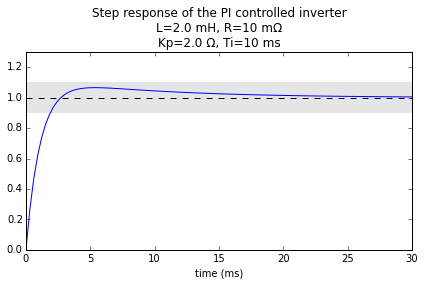

In [368]:
T_step = 0.03 #s

def step_plot(mL=L*1000,R=R, Kp=Kp, mTi=Ti*1000):
    L = mL*1e-3
    Ti = mTi*1e-3
    
    cl_sys = sig.lti([Kp*Ti, Kp], [Ti*L,Kp*Ti + R*Ti, Kp])
    # compute step response
    t_step = np.linspace(0, T_step, 100)
    t, h = cl_sys.step(T=t_step)
    t *= 1000
    # plot
    plt.plot(t, h)
    ax = plt.gca()
    ax.fill_between(t, 0.9, 1.1, linewidth=0, color='black', alpha=0.1)
    ax.hlines(1, t[0], t[-1], linestyles='dashed')
    title = u'''Step response of the PI controlled inverter
L={:.1f} mH, R={:.0f} mΩ
Kp={:.1f} Ω, Ti={:.0f} ms'''
    ax.set(title=title.format(L*1e3,R*1e3,Kp,Ti*1000),
           xlabel = 'time (ms)',
           ylim=(0, 1.3))
    plt.tight_layout()
    #plt.savefig('step_response.png', dpi=150)

interact(step_plot, **interact_params);

Note that the PWM delay is *not taken into account* in this transcient simulation.

### Transcient of the control (voltage)

$$ U/I^* = (U/I) . (I/I^*) = H^{-1} . H_{cl}$$

therefore, the control tranfser function, in closed loop is:

$$ H_{ctrl} = (R+Ls) . H_{cl}$$

Properties:

* static gain: $R$ 
* HF gain: $K_p$

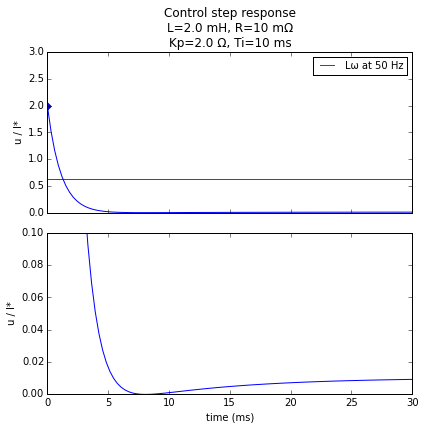

In [370]:
def step_plot_control(mL=L*1000,R=R, Kp=Kp, mTi=Ti*1000):
    L = mL*1e-3
    Ti = mTi*1e-3
    
    cl_sys = sig.lti([Kp*Ti*L, Kp*(L+Ti*R), Kp*R],
                     [Ti*L,Kp*Ti + R*Ti, Kp])
    # compute step response
    t_step = np.linspace(0, T_step, 100)
    t, h = cl_sys.step(T=t_step)
    t *= 1000
    
    # plot
    fig, (ax1, ax2) = plt.subplots(2,1, sharex=True, figsize=(6,6))
    ax1.plot(t, h)
    ax1.plot(t[0], h[0], 'bD')
    ax1.hlines(X_50Hz, 0 , 30, colors='r', label=u'Lω at 50 Hz')
    ax1.legend(loc='upper right')
    title = u'''Control step response
L={:.1f} mH, R={:.0f} mΩ
Kp={:.1f} Ω, Ti={:.0f} ms'''
    ax1.set(title=title.format(L*1e3,R*1e3,Kp,Ti*1000),
            ylabel='u / I*',
            ylim=(0,3))
    ax1.set_ylim(0,3)
    
    ax2.plot(t, h)
    ax1.hlines(X_50Hz, 0 , 30, colors='r', label=u'Lω at 50 Hz')
    ax2.set(xlabel = 'time (ms)',
            ylabel='u / I*',
            ylim=(0,0.1)
    )
    fig.tight_layout()
    #fig.savefig('control_response.png', dpi=150)

interact(step_plot_control, **interact_params);